In [1]:
import pandas as pd
pd.set_option('display.float_format', str)  # set float formatting

import numpy as np
import sklearn
import os
import json
import matplotlib.pyplot as plt
import datetime
from datetime import datetime
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import SGDRegressor
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
import json
import yaml
import seaborn as sns

import tensorflow as tf
from keras import Sequential
from keras.layers import Dense


In [2]:
updated_df = pd.read_csv('updated_requests_training_data.csv')  # todo: drop t1
updated_df = updated_df.loc[:, ~updated_df.columns.str.contains('^Unnamed')]
updated_df.columns

Index(['sim_time', 'wind_direction', 'wind_speed', 'canopy_moisture',
       'surface_moisture', 'run_max_mem_rss_bytes', 'threads', 'area',
       'runtime', 'cpu_usage_total', 'mem_usage_total', 'duration_t1',
       'duration_t2', 'run_uuid', 'transmitted_packets_total',
       'received_packets_total', 'transmitted_bandwidth_total',
       'received_bandwidth_total', 'cpu_request', 'mem_request',
       'cpu_request_%_total', 'mem_request_%_total', 'cpu_usage_t1_ratio',
       'mem_usage_t1_ratio', 'cpu_request_%_t1_ratio',
       'mem_request_%_t1_ratio', 'transmitted_packets_t1_ratio',
       'received_packets_t1_ratio', 'transmitted_bandwidth_t1_ratio',
       'received_bandwidth_t1_ratio', 'cpu_usage_t2_ratio',
       'mem_usage_t2_ratio', 'cpu_request_%_t2_ratio',
       'mem_request_%_t2_ratio', 'transmitted_packets_t2_ratio',
       'received_packets_t2_ratio', 'transmitted_bandwidth_t2_ratio',
       'received_bandwidth_t2_ratio'],
      dtype='object')

In [3]:
# remove columns for t1
df_t2_cols = [col for col in updated_df.columns if "t1" not in col]
df_t2 = updated_df[df_t2_cols].drop(columns=['cpu_request'], axis=1)

# create new columns cpu and mem usage ratios and totals to get t2 totals
df_t2["CPU Usage"] = df_t2["cpu_usage_t2_ratio"]*df_t2["cpu_usage_total"]
df_t2["Memory Usage"] = df_t2["mem_usage_t2_ratio"]*df_t2["mem_usage_total"]
df_t2["transmitted_packages_t2"] = df_t2["transmitted_packets_t2_ratio"]*df_t2["transmitted_packets_total"]
df_t2["received_packets_t2"] = df_t2["received_packets_t2_ratio"]*df_t2["received_packets_total"]
df_t2["received_bandwidth_t2"] = df_t2["received_bandwidth_t2_ratio"]*df_t2["received_bandwidth_total"]
df_t2["transmitted_bandwidth_t2"] = df_t2["transmitted_bandwidth_t2_ratio"]*df_t2["transmitted_bandwidth_total"]
df_t2["memory_requests_t2"] = df_t2['mem_request_%_t2_ratio']*df_t2['mem_request']


# # remove t2 label from all columns
# new_t2_cols = [col.replace('t2', '') for col in df_t2.columns]
# df_t2.rename(columns=dict(zip(new_t2_cols, df_t2.columns)))

df_t2

,sim_time,wind_direction,wind_speed,canopy_moisture,surface_moisture,run_max_mem_rss_bytes,threads,area,runtime,cpu_usage_total,...,received_packets_t2_ratio,transmitted_bandwidth_t2_ratio,received_bandwidth_t2_ratio,CPU Usage,Memory Usage,transmitted_packages_t2,received_packets_t2,received_bandwidth_t2,transmitted_bandwidth_t2,memory_requests_t2
0,6183,120.0,2.235,0.9,0.1,10737056,1,1854216.0,15292.0,25932.31336147627,...,0.2166666666666666,19.01666666666667,59.07777777777778,25094.600144961696,1.1636693235982915e+18,3435.0076513458434,13821.498099481187,37432834275.46785,2657621929.8708105,5198773881.9047575
1,6183,60.0,2.235,0.9,0.1,10737788,1,1854216.0,20162.0,18248.865107783982,...,0.0333333333333333,0.0,8.133333333333335,37046.74760762587,7.296188484739009e+18,0.0,374.2102367322287,19545103.67224375,0.0,32592330507.462692
2,6183,90.0,2.235,0.9,0.1,10737472,1,1854216.0,21036.0,33345.25154672648,...,0.1955572839698219,17.734621051345016,103.31171716722778,67761.43498853933,3.9346228975959163e+18,7763.926271672633,14198.80631370915,65544770663.578,4701126740.451003,11719516376.719576
3,25457,320.0,2.235,1.2,0.08,9803028,1,1854216.0,32745.0,745761.1479483792,...,2.9317182051459003,302.35451658655734,994.4504412678372,15709810.921793418,1.070922345896748e+21,2219228.3930523233,3428078.356799694,2320769122100.2866,1782370981700.912,401703355733.3333
4,25457,320.0,2.235,1.0,0.08,9802992,1,1854216.0,33007.0,747807.1743456394,...,3.016659168652852,314.8648593374319,980.9604342966716,16652713.066340819,8.679386215650334e+20,2434551.050325312,3588980.1277459785,2291420582360.4536,1994783887526.8147,325562672432.43243
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
912,7251,331.0,4.47,0.9,0.08,2269772,1,1404696.0,6423.0,5795.704846277236,...,1.6444444444444446,211.02777777777777,626.4055555555557,18796.950279549135,5.2811738608654e+17,10778.418971540746,10407.180936178389,1092169955.994737,5546494265.018408,7147369948.514851
913,7251,1.0,4.47,0.9,0.08,2269556,1,1404696.0,5182.0,5800.111292324419,...,1.7697701713698868,228.4743364142671,677.4807386623331,18363.262846079597,2.409001121737605e+17,11614.336708197918,11203.92491035564,1182203276.601558,6008830772.702319,3260264228.5714283
914,4139,126.0,1.788,0.86,0.12,3913120,1,648024.0,3155.0,136.92845517775592,...,0.1952032991135904,25.19263558015269,74.94745606873344,113.1302811906185,1.020397372875735e+17,7.498707445154912,6.315391604153769,931963.9031294495,105222.06742405398,2479308799.9999967
915,4139,96.0,1.788,0.86,0.12,3914004,1,648024.0,3592.0,137.18597881380012,...,0.0,0.0,0.0,132.1759836525481,2.605891223215649e+17,0.0,0.0,0.0,0.0,6331659815.384613


In [77]:
df_t2.columns

Index(['sim_time', 'wind_direction', 'wind_speed', 'canopy_moisture',
       'surface_moisture', 'run_max_mem_rss_bytes', 'threads', 'area',
       'runtime', 'cpu_usage_total', 'mem_usage_total', 'duration_t2',
       'run_uuid', 'transmitted_packets_total', 'received_packets_total',
       'transmitted_bandwidth_total', 'received_bandwidth_total',
       'mem_request', 'cpu_request_%_total', 'mem_request_%_total',
       'cpu_usage_t2_ratio', 'mem_usage_t2_ratio', 'cpu_request_%_t2_ratio',
       'mem_request_%_t2_ratio', 'transmitted_packets_t2_ratio',
       'received_packets_t2_ratio', 'transmitted_bandwidth_t2_ratio',
       'received_bandwidth_t2_ratio', 'CPU Usage', 'Memory Usage',
       'transmitted_packages_t2', 'received_packets_t2',
       'received_bandwidth_t2', 'transmitted_bandwidth_t2',
       'memory_requests_t2'],
      dtype='object')

# Pearson Coefficient Analysis for Regression

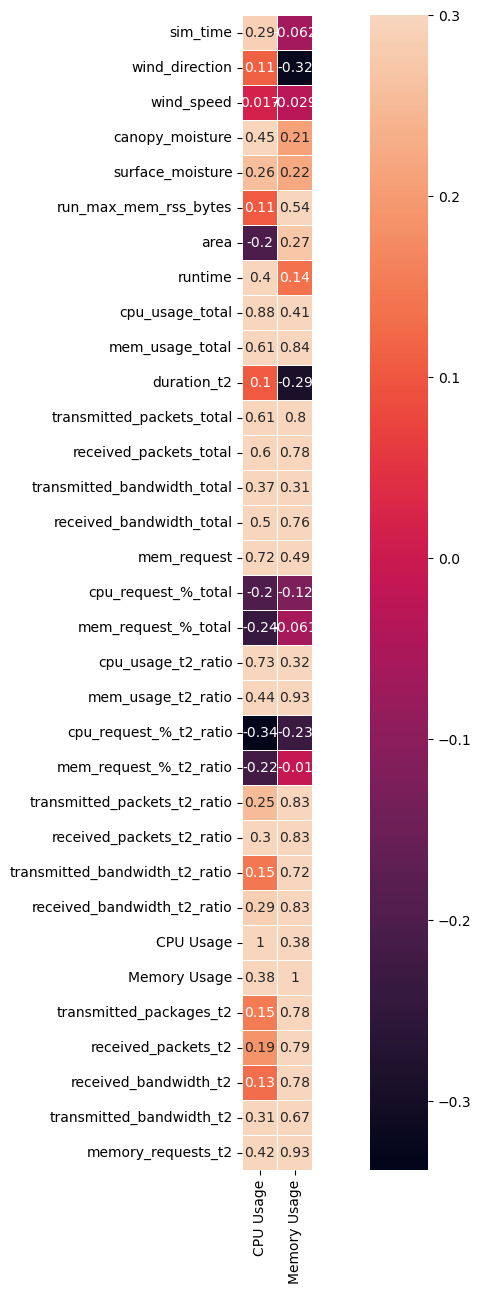

In [83]:
# Compute the correlation matrix
features = df_t2.drop(columns=['run_uuid', 'threads'])
corr = features.corr()
dep_vars = corr[['CPU Usage', 'Memory Usage']]  # define target variables


# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(20,20))

# Draw the heatmap with a mask and correct aspect ratio
# cmap = sns.diverging_palette(230, 170, as_cmap=True)  # Generate a custom diverging colormap
# mask = np.triu(np.ones_like(dep_vars, dtype=bool))  # Generate a mask for the upper triangle
cmap = sns.color_palette("rocket", as_cmap=True)
f = sns.heatmap(dep_vars, cmap=cmap, vmax=1, vmin=-1, center=0, 
            annot=True,square=True, linewidths=.5, cbar_kws= {'orientation': 'vertical'})

fig = f.get_figure()  # show figure
fig.savefig("corr_matrix", bbox_inches='tight')

In [84]:
cpu_high_corr = ['cpu_usage_t2_ratio', 'received_bandwidth_total', 'mem_request', 'mem_usage_total', 'transmitted_packets_total']
mem_high_corr = ['memory_requests_t2', 'transmitted_bandwidth_t2', 'received_bandwidth_t2', 
                  'received_packets_t2', 'received_bandwidth_t2_ratio', 'transmitted_bandwidth_t2_ratio',
                 'received_packets_t2_ratio', 'transmitted_packets_t2_ratio', 'mem_usage_t2_ratio', 'mem_usage_total',
                 'received_packets_total', 'received_bandwidth_total', 'run_max_mem_rss_bytes']

In [86]:
random_state = int(round(datetime.now().timestamp()))
# Split data for training and testing
train = df_t2.sample(random_state=random_state, frac=0.3, axis=0).dropna()
test = df_t2.drop(train.index, axis=0).dropna()

In [91]:
# Create train/test sets for CPU and memory predictionscpu_train = train[cpu_high_corr]
mem_train = train[mem_high_corr]

cpu_test = test[cpu_high_corr]
mem_test = test[mem_high_corr]

cpu_train_labels = train['CPU Usage']
cpu_test_labels = test['CPU Usage']

# Get train and test labels for Memory usage prediction
mem_train_labels = train['Memory Usage'] 
mem_test_labels = test['Memory Usage']

In [10]:
mem_test_labels

0       1698664299.339
1       1698664299.339
3       1698664299.339
4       1698664299.339
5       1698664299.339
             ...      
79008   1698664321.164
79009   1698664321.164
79010   1698664321.164
79011   1698664321.164
79013   1698664321.164
Name: Memory Usage, Length: 15125, dtype: float64

# Feature Analysis for MAB

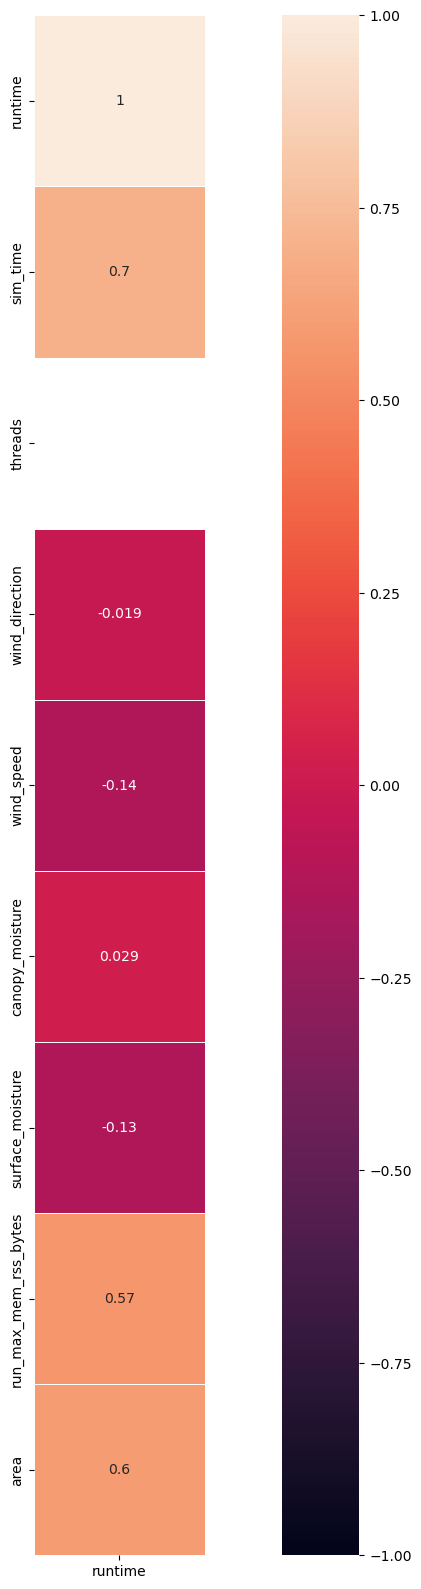

In [16]:
# Compute the correlation matrix
mab_features = df_t2[['runtime', 'sim_time', 'timestep', 'wind_direction', 'wind_speed', 'canopy_moisture', 'surface_moisture', 'run_max_mem_rss_bytes', 'area']]
mab_corr = mab_features.corr()
mab_dep_vars = mab_corr[['runtime']]  # define target variables


# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(20,20))

# Draw the heatmap with a mask and correct aspect ratio
# cmap = sns.diverging_palette(230, 170, as_cmap=True)  # Generate a custom diverging colormap
# mask = np.triu(np.ones_like(dep_vars, dtype=bool))  # Generate a mask for the upper triangle
mab_cmap = sns.color_palette("rocket", as_cmap=True)
f = sns.heatmap(mab_dep_vars, cmap=mab_cmap, vmax=1, vmin=-1, center=0, 
            annot=True,square=True, linewidths=.5, cbar_kws= {'orientation': 'vertical'})

fig = f.get_figure()  # show figure
fig.savefig("mab_corr_matrix", bbox_inches='tight')

# AI methods (experimental)

In [92]:
# create dictionaries to store performance on prediction evaluation metrics
eval_cpu = pd.DataFrame({'method':['Linear Regression', 'Decision Tree', 'Random Forest', 'Neural Net'], 'r-squared':np.nan, 'mean absolute error':np.nan, 'mean squared error':np.nan})
eval_mem = pd.DataFrame({'method':['Linear Regression', 'Decision Tree', 'Random Forest', 'Neural Net'], 'r-squared':np.nan, 'mean absolute error':np.nan, 'mean squared error':np.nan})

## Multivariate Linear Regression

In [93]:
# Build linear regression model
linear_model = LinearRegression()

In [94]:
### Linear Regression for CPU Usage prediction

In [95]:
linear_model.fit(cpu_train, cpu_train_labels)  # Fit model to training data for CPU prediction
linreg_cpu_pred = linear_model.predict(cpu_test)  # Make prediction


print('r-squared:', metrics.r2_score(cpu_test_labels, linreg_cpu_pred))
print('MAE: ', metrics.mean_absolute_error(cpu_test_labels, linreg_cpu_pred))
print('MSE: ', metrics.mean_squared_error(cpu_test_labels, linreg_cpu_pred))

r-squared: 0.706262099580227
MAE:  12949482.704924863
MSE:  291841722746708.9


In [96]:
# Fit model and make prediction for memory usage
linear_model.fit(mem_train, mem_train_labels)  
linreg_mem_pred = linear_model.predict(mem_test)


# Print the evaluation metrics
print('r-squared:', metrics.r2_score(mem_test_labels, linreg_mem_pred))
print('MAE: ', metrics.mean_absolute_error(mem_test_labels, linreg_mem_pred))
print('MSE: ', metrics.mean_squared_error(mem_test_labels, linreg_mem_pred))

r-squared: 0.9221460382351903
MAE:  7.071759421566277e+19
MSE:  9.728670196481623e+39


In [97]:
def show_plots(predictions, y_test, s=4):
    plt.figure(figsize=(10,10))
    plt.scatter(y_test, predictions, c='crimson')
    plt.yscale('log')
    plt.xscale('log')
    
    p1 = max(max(predictions), max(y_test))
    p2 = min(min(predictions), min(y_test))
    plt.plot([p1, p2], [p1, p2], 'b-')
    plt.xlabel('True Values', fontsize=15)
    plt.ylabel('Predictions', fontsize=15)
    plt.axis('equal')
    plt.show()

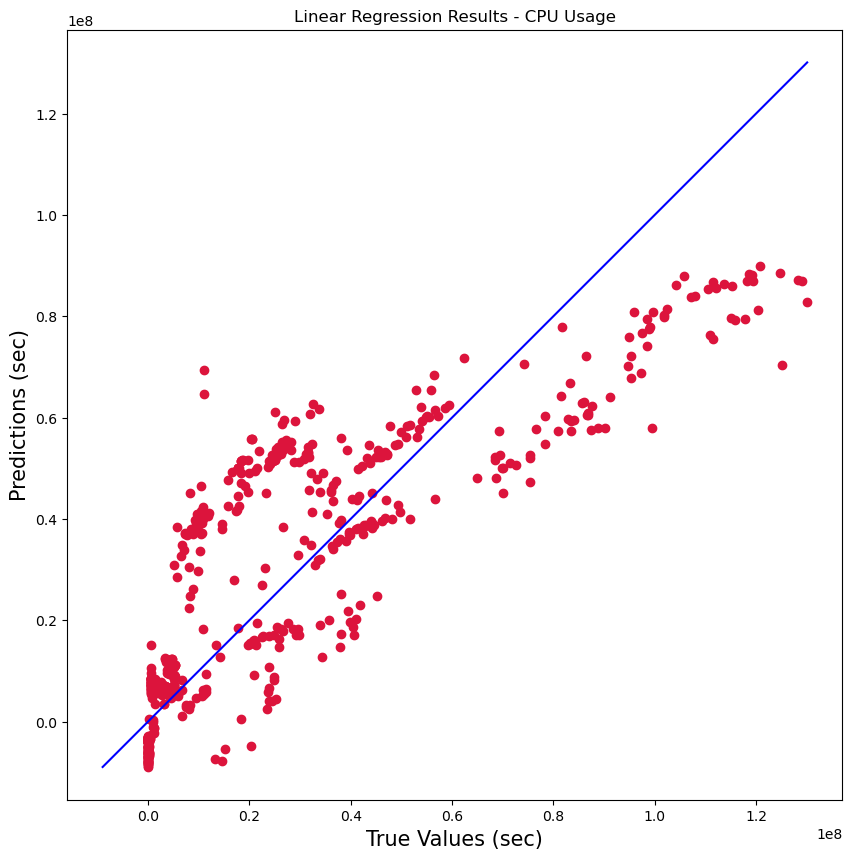

<Figure size 640x480 with 0 Axes>

In [110]:
plt.figure(figsize=(10,10))
plt.scatter(cpu_test_labels, linreg_cpu_pred, c='crimson')
# plt.yscale('log')
# plt.xscale('log')

p1 = max(max(linreg_cpu_pred), max(cpu_test_labels))
p2 = min(min(linreg_cpu_pred), min(cpu_test_labels))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values (sec)', fontsize=15)
plt.ylabel('Predictions (sec)', fontsize=15)
plt.axis('equal')
plt.title('Linear Regression Results - CPU Usage')
plt.savefig('linreg_cpu', bbox_inches='tight')
plt.show()
plt.savefig("lin_reg_cpu", bbox_inches='tight')

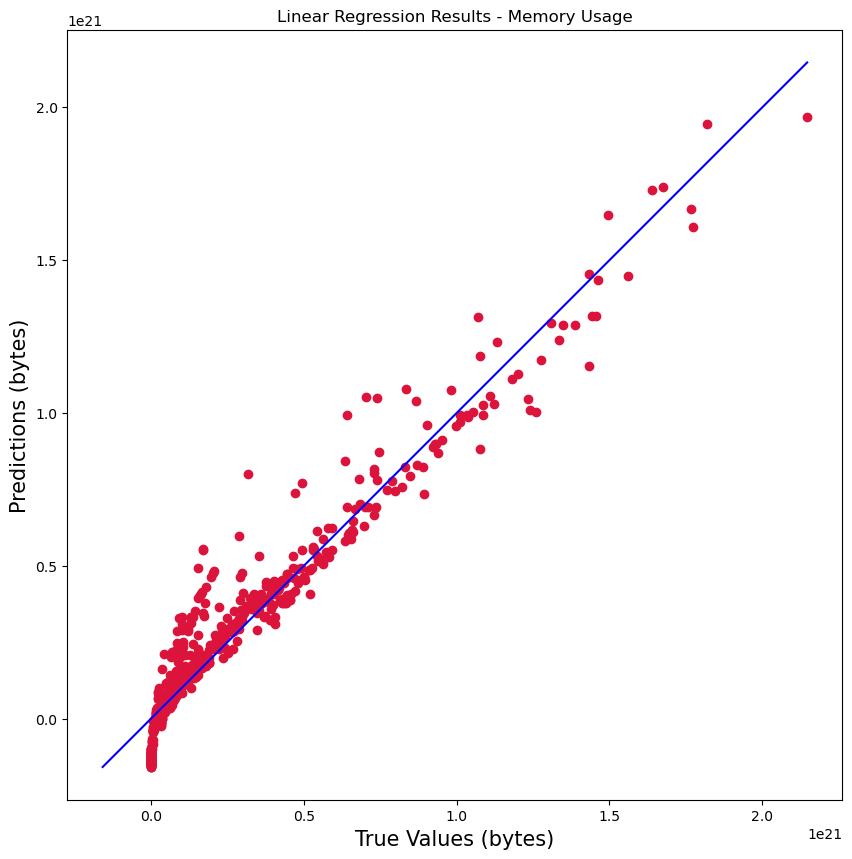

<Figure size 640x480 with 0 Axes>

In [111]:
plt.figure(figsize=(10,10))
plt.scatter(mem_test_labels, linreg_mem_pred, c='crimson')
# plt.yscale('log')
# plt.xscale('log')

p1 = max(max(linreg_mem_pred), max(mem_test_labels))
p2 = min(min(linreg_mem_pred), min(mem_test_labels))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values (bytes)', fontsize=15)
plt.ylabel('Predictions (bytes)', fontsize=15)
plt.axis('equal')
plt.title('Linear Regression Results - Memory Usage')
plt.savefig('linreg_mem', bbox_inches='tight')
plt.show()
plt.savefig("lin_reg_mem", bbox_inches='tight')

In [100]:
# statsmodel
from sklearn import feature_selection
cpu_stats = sklearn.feature_selection.f_regression(cpu_train, cpu_train_labels)
print(cpu_stats)

(array([301.384741  ,  66.34175611, 296.3450112 , 124.74087597,
       125.9392092 ]), array([1.47305488e-45, 1.51908763e-14, 4.82174497e-45, 5.63291939e-24,
       3.74035968e-24]))


In [101]:
# Vizualizations

## Decision Tree

In [102]:
decision_tree = DecisionTreeRegressor(random_state=random_state)

In [103]:
decision_tree.fit(cpu_train, cpu_train_labels)  # Fit model to training data for CPU prediction
dectree_cpu_pred = decision_tree.predict(cpu_test)  # Make prediction


# Print the evaluation metrics
print('r-squared:', metrics.r2_score(cpu_test_labels, dectree_cpu_pred))
print('MAE: ', metrics.mean_absolute_error(cpu_test_labels, dectree_cpu_pred))
print('MSE: ', metrics.mean_squared_error(cpu_test_labels, dectree_cpu_pred))

r-squared: 0.9691272276532537
MAE:  2474780.489754317
MSE:  30673478140769.387


In [104]:
decision_tree.fit(mem_train, mem_train_labels)  
dectree_mem_pred = decision_tree.predict(mem_test)

# Print the evaluation metrics
print('r-squared:', metrics.r2_score(mem_test_labels, dectree_mem_pred))
print('MAE: ', metrics.mean_absolute_error(mem_test_labels, dectree_mem_pred))
print('MSE: ', metrics.mean_squared_error(mem_test_labels, dectree_mem_pred))

r-squared: 0.9371552638726564
MAE:  2.9833190693414023e+19
MSE:  7.8531098162328e+39


## Display comparison

In [105]:
eval_cpu = eval_cpu.set_index('method')
eval_mem = eval_mem.set_index('method')

In [106]:
eval_cpu['r-squared'] = [metrics.r2_score(cpu_test_labels, linreg_cpu_pred), metrics.r2_score(cpu_test_labels, dectree_cpu_pred), 'na', 'na']
eval_cpu['mean absolute error'] = [metrics.mean_absolute_error(cpu_test_labels, linreg_cpu_pred), metrics.mean_absolute_error(cpu_test_labels, dectree_cpu_pred), 'na', 'na']
eval_cpu['mean squared error'] = [metrics.mean_squared_error(cpu_test_labels, linreg_cpu_pred), metrics.mean_squared_error(cpu_test_labels, dectree_cpu_pred), 'na', 'na']
eval_cpu

,r-squared,mean absolute error,mean squared error
method,,,
Linear Regression,0.706262099580227,12949482.704924863,291841722746708.9
Decision Tree,0.9691272276532537,2474780.489754317,30673478140769.387
Random Forest,na,na,na
Neural Net,na,na,na


In [26]:
eval_mem['r-squared'] = [metrics.r2_score(mem_test_labels, linreg_mem_pred), metrics.r2_score(mem_test_labels, dectree_mem_pred), 'na', 'na']
eval_mem['mean absolute error'] = [metrics.mean_absolute_error(mem_test_labels, linreg_mem_pred), metrics.mean_absolute_error(mem_test_labels, dectree_mem_pred), 'na', 'na']
eval_mem['mean squared error'] = [metrics.mean_squared_error(mem_test_labels, linreg_mem_pred), metrics.mean_squared_error(mem_test_labels, dectree_mem_pred), 'na', 'na']
eval_mem

,r-squared,mean absolute error,mean squared error
method,,,
Linear Regression,0.9999999999999931,6.179651938194086e-07,4.673261887659434e-13
Decision Tree,-9.05294983422067e-08,7.98391284673076,67.86889862053371
Random Forest,na,na,na
Neural Net,na,na,na
